In [1]:
import pandas as pd
import numpy as np
n_movies = pd.read_csv('n_movies.csv')

In [2]:
# Turns genre string into list
n_movies['genre'] = n_movies['genre'].str.split(', ')

In [3]:
# Gets only movies with ratings
wrangled_n_movies = n_movies.loc[n_movies["rating"].notnull()]
wrangled_n_movies.head()

,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"[Action, Comedy, Drama]",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"[Biography, Drama, History]",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"[Crime, Drama]",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"[Drama, Horror, Mystery]",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"[Animation, Action, Adventure]",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"


In [4]:
# Loads second dataset, makes variables line up between datasets
netflix_titles = pd.read_csv("netflix_titles.csv")
netflix_titles['certificate'] = netflix_titles['rating']
netflix_titles.drop('rating', axis=1, inplace=True)
netflix_titles.head()

,show_id,type,title,director,cast,country,date_added,release_year,duration,listed_in,description,certificate
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,90 min,Documentaries,"As her father nears the end of his life, filmm...",PG-13
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",TV-MA
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,TV-MA
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",TV-MA
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,TV-MA


In [5]:
merged_data = netflix_titles.merge(wrangled_n_movies, how='inner', on='title') #inner join on title
#print(merged_data)
merged_data.rename(columns={'duration_x':'seasons / movie length', 'duration_y': 'episode / movie length'}, inplace=True)

#get rid of trailing 'min' in episode / movie length column:
merged_data['episode / movie length'] = merged_data['episode / movie length'].replace(r'min$' , regex = True, value='')

#turn values in episode / movie length column to float so we can perform computations on them:
merged_data['episode / movie length'] = merged_data['episode / movie length'].astype(float)

#get rid of trailing 'min' in seasons / movie length column:
merged_data['seasons / movie length'] = merged_data['seasons / movie length'].replace(r'min$' , regex = True, value='')

merged_data.head()
num_observations = len(merged_data)

In [6]:
#group by title to get average rating for title - this is needed because individual episodes are listed, 
#so we want the average rating for a show based on individual episode ratings: 
grouped_rating= merged_data.groupby('title')['rating'].mean().to_frame().reset_index()

#renaming this column for clarity:
grouped_rating.rename(columns={'rating':'average rating'}, inplace=True)

#group by title to get average length of the episode / movie - this is needed for the same reason listed above
grouped_episode_duration = merged_data.groupby('title')['episode / movie length'].mean().to_frame().reset_index()

grouped_episode_duration.rename(columns={'episode / movie length':'average episode / movie length'}, inplace=True)

In [7]:
#making a copy of the merged data set to preserve the original one:
merged_data_copy = merged_data.copy()

#merge rating group by with merged data set to get a column with average rating
merge_average_rating = pd.merge(merged_data_copy, grouped_rating)

#merge the new df with the average rating column with average episode duration
merge_with_two_avg_col = pd.merge(merge_average_rating, grouped_episode_duration)

#same as the original merged_data, but now has two columns for average rating and average episode / movie length

In [8]:
#make a copy of the df above with the two average columns to have final cleaned data set
cleaned_data_set = merge_with_two_avg_col.copy()

cleaned_tv_shows = cleaned_data_set[cleaned_data_set["type"] == 'TV Show']

#just movies in clean set
cleaned_movies = cleaned_data_set[cleaned_data_set["type"] == 'Movie']

In [9]:
#extract the month added and add to a column

dates_parsed = merge_with_two_avg_col.copy()
dates_parsed['month added'] = dates_parsed['date_added'].replace(r'[\d\s,]+' , regex = True, value='')

#parses stars to get the number for each movie
dates_parsed['list # of stars'] = dates_parsed['stars'].apply(eval)

stars_df = dates_parsed['list # of stars'].apply(pd.Series)
stars_df.columns = ['s0','s1','s2','s3','s4','s5','s6','s7','s8','s9',
                    's10','s11','s12','s13','s14','s15','s16','s17','s18']

stars_df["s1"] = stars_df["s1"].replace(r'|' , regex = True, value = np.nan)

stars_df["director?"] = np.where(stars_df['s2'].str.contains("Stars"), 'director', 'no director')
stars_df["s0"] = np.where(stars_df['director?'].str.contains("no"), stars_df["s0"], np.NaN)
stars_df["s2"] = stars_df["s2"].replace(r'Stars:' , regex = True, value = np.nan)

stars_df = stars_df.drop('director?', axis=1)

dates_parsed_and_stars_count = dates_parsed.copy()
dates_parsed_and_stars_count = dates_parsed_and_stars_count.drop('list # of stars', axis=1)
dates_parsed_and_stars_count["star count"] = stars_df.count(axis=1)

dates_parsed_tv = dates_parsed[dates_parsed["type"] == 'TV Show']
dates_parsed_movie = dates_parsed[dates_parsed["type"] == 'Movie']

dates_parsed_and_stars_count_tv = dates_parsed_and_stars_count[dates_parsed_and_stars_count["type"] == 'TV Show']
dates_parsed_and_stars_count_movies = dates_parsed_and_stars_count[dates_parsed_and_stars_count["type"] == 'Movie']

# Makes separate rows for each genre for movies that have multiple genres listed
cleaned_tv_shows['genre'] = cleaned_tv_shows['genre'].astype(object)
cleaned_tv_shows_genre = cleaned_tv_shows.explode('genre')

cleaned_movies['genre'] = cleaned_movies['genre'].astype(object)
cleaned_movies_genre = cleaned_movies.explode('genre')

#https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_14138/1643851653.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stars_df = dates_parsed['list # of stars'].apply(pd.Series)
/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_14138/1643851653.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_tv_shows['genre'] = cleaned_tv_shows['genre'].astype(object)
/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_14138/1643851653.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

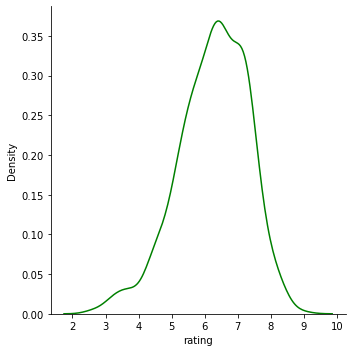

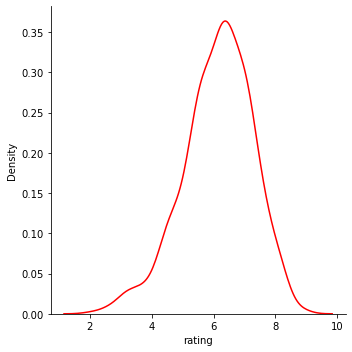

In [11]:
# Playing around with countries, didn't include in a visualization just looked/made sense of what we saw
cleaned_movies_country = cleaned_movies.copy()

us_movies = cleaned_movies_country[cleaned_movies_country['country']=='United States']
not_us_movies = cleaned_movies_country[cleaned_movies_country['country']!='United States']

sns.displot(x='rating', data=us_movies, kind = 'kde', color='g')
sns.displot(x='rating', data=not_us_movies, kind = 'kde', color='r')

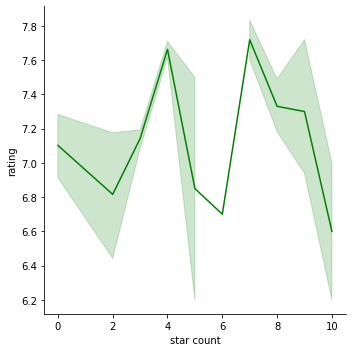

In [12]:
sns.relplot(x="star count", y="rating", data=dates_parsed_and_stars_count_tv, kind="line", color='g')

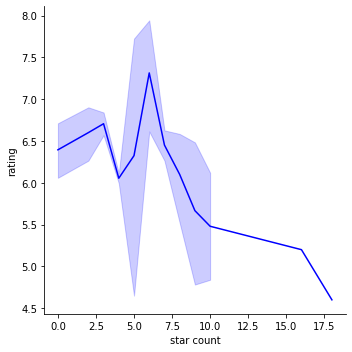

In [13]:
sns.relplot(x="star count", y="rating", data=dates_parsed_and_stars_count_movies, kind="line", color='b')

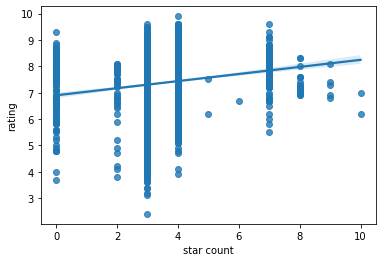

In [14]:
sns.regplot(x='star count', y='rating', data=dates_parsed_and_stars_count_tv);

/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_14138/1170935529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']==3, 3, dates_parsed_and_stars_count_tv['star count'])
/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_14138/1170935529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv[

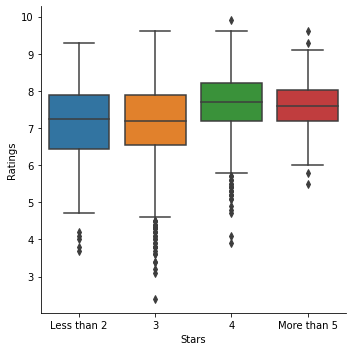

In [15]:
# Make buckets for star counts and plot star count vs. rating for tv
dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']==3, 3, dates_parsed_and_stars_count_tv['star count'])
dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']==4, 4, dates_parsed_and_stars_count_tv['star count'])
dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']>=5, 'More than 5', dates_parsed_and_stars_count_tv['star count'])
dates_parsed_and_stars_count_tv['star_simplified'] = np.where(dates_parsed_and_stars_count_tv['star count']<=2, 'Less than 2', dates_parsed_and_stars_count_tv['star_simplified'])

graph = sns.catplot(data=dates_parsed_and_stars_count_tv, 
            x="star_simplified", 
            y="rating", 
            kind="box", 
            order=['Less than 2', '3', '4', 'More than 5'])
graph.set_axis_labels('Stars', 'Ratings')

/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_14138/363806599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']==3, 3, dates_parsed_and_stars_count_movies['star count'])
/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_14138/363806599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_s

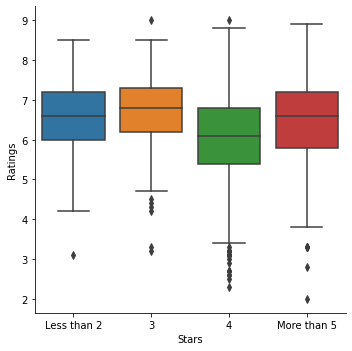

In [16]:
# Make buckets for star counts and plot star count vs. rating for movies
dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']==3, 3, dates_parsed_and_stars_count_movies['star count'])
dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']==4, 4, dates_parsed_and_stars_count_movies['star count'])
dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']>=5, 'More than 5', dates_parsed_and_stars_count_movies['star count'])
dates_parsed_and_stars_count_movies['star_simplified'] = np.where(dates_parsed_and_stars_count_movies['star count']<=2, 'Less than 2', dates_parsed_and_stars_count_movies['star_simplified'])

graph = sns.catplot(data=dates_parsed_and_stars_count_movies, 
            x="star_simplified", 
            y="rating", 
            kind="box", 
            order=['Less than 2', '3', '4', 'More than 5'])
graph.set_axis_labels('Stars', 'Ratings')

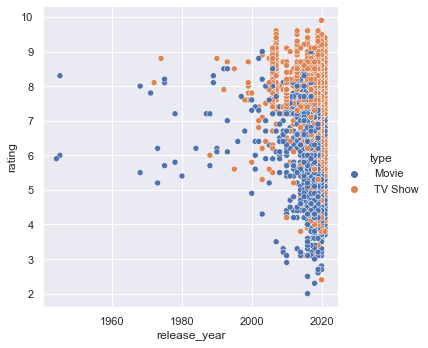

In [17]:
sns.set_theme()
sns.relplot(x='release_year', y='rating', hue="type", data=cleaned_data_set);

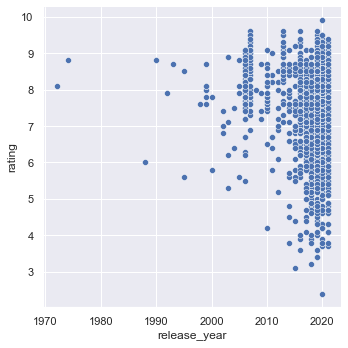

In [18]:
sns.relplot(x='release_year', y='rating', data=cleaned_tv_shows, color='b')

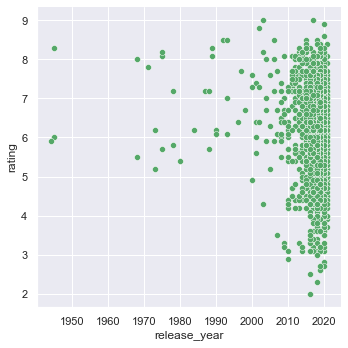

In [19]:
sns.relplot(x='release_year', y='rating', data=cleaned_movies, color='g')

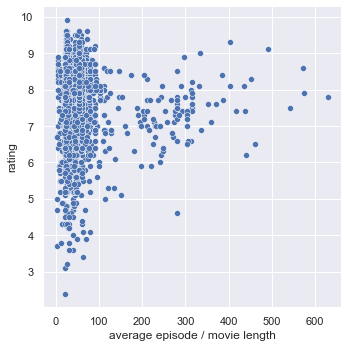

In [20]:
sns.relplot(x='average episode / movie length', y='rating', data=cleaned_tv_shows, color='b')

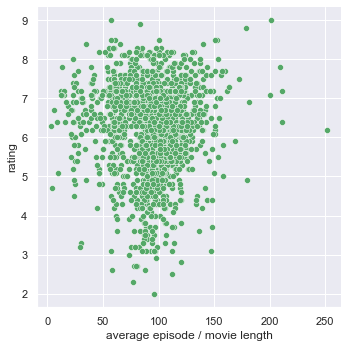

In [21]:
sns.relplot(x='average episode / movie length', y='rating', data=cleaned_movies, color='g')

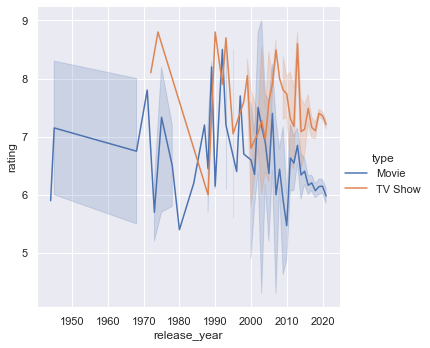

In [22]:
sns.relplot(x="release_year", y="rating", data=cleaned_data_set, hue='type', kind="line")

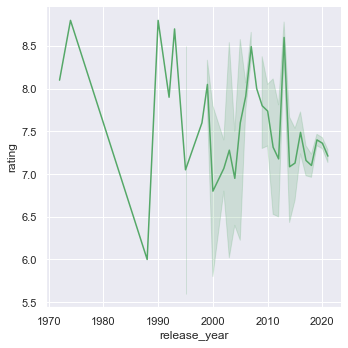

In [23]:
sns.relplot(x="release_year", y="rating", data=cleaned_tv_shows, kind="line", color='g')

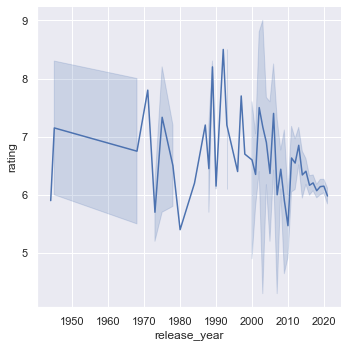

In [24]:
sns.relplot(x="release_year", y="rating", data=cleaned_movies, kind="line", color='b')

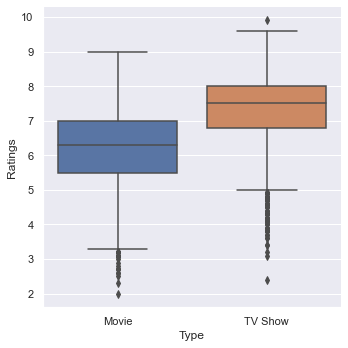

In [25]:
graph = sns.catplot(data=cleaned_data_set, x="type", y="rating", kind="box")
graph.set_axis_labels('Type', 'Ratings')

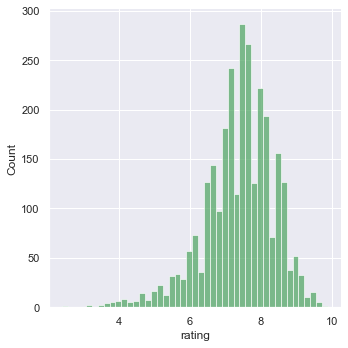

In [26]:
sns.displot(data=cleaned_tv_shows, x="rating", color='g')

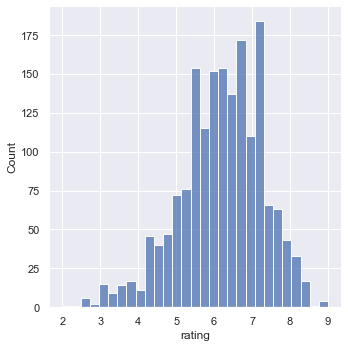

In [27]:
graph = sns.displot(data=cleaned_movies, x="rating")

/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_14138/1849468308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_tv["month added"] = pd.Categorical(dates_parsed_tv["month added"], months)


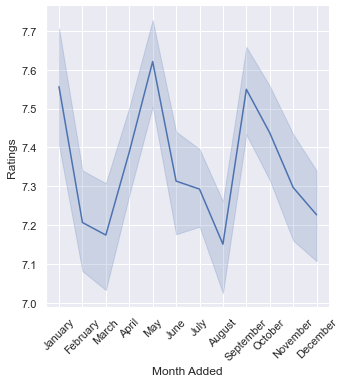

In [28]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

dates_parsed_tv["month added"] = pd.Categorical(dates_parsed_tv["month added"], months)

graph = sns.relplot(x="month added", y="rating", data=dates_parsed_tv, kind="line", color='b')# col_order=months)
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Month Added', 'Ratings')

/var/folders/d5/n14y0j997zb1ws368_lxlkj80000gn/T/ipykernel_14138/3394915951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_parsed_movie["month added"] = pd.Categorical(dates_parsed_movie["month added"], months)


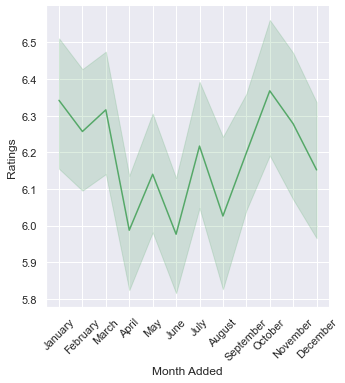

In [29]:
dates_parsed_movie["month added"] = pd.Categorical(dates_parsed_movie["month added"], months)

graph = sns.relplot(x="month added", y="rating", data=dates_parsed_movie, kind="line", color='g')
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Month Added', 'Ratings')

In [30]:
# Cleaned certificate data to make mask/get all data with the listed certificates
proper_tv_ratings_mask = ((cleaned_tv_shows['certificate_y'] == 'TV-14') | 
(cleaned_tv_shows['certificate_y'] == 'TV-MA') |
(cleaned_tv_shows['certificate_y'] == 'TV-PG') | 
(cleaned_tv_shows['certificate_y'] == 'TV-Y7') |
(cleaned_tv_shows['certificate_y'] == 'TV-Y') |
(cleaned_tv_shows['certificate_y'] == 'TV-Y7-FV') |
(cleaned_tv_shows['certificate_y'] == 'TV-G'))

proper_tv_ratings = cleaned_tv_shows[proper_tv_ratings_mask]


proper_movie_ratings_mask = ((cleaned_movies['certificate_y'] == 'PG-13') |
                             (cleaned_movies['certificate_y'] == 'PG') |
                             (cleaned_movies['certificate_y'] == 'R') |
                            (cleaned_movies['certificate_y'] == 'G') |
                            (cleaned_movies['certificate_y'] == 'NC-17'))
proper_movie_ratings = cleaned_movies[proper_movie_ratings_mask]


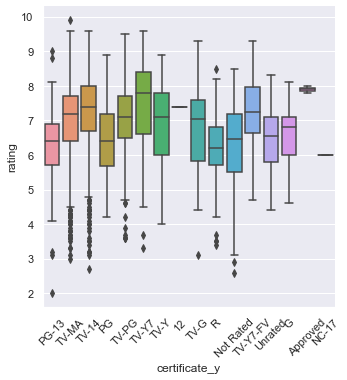

In [31]:
graph = sns.catplot(data=dates_parsed, x="certificate_y", y="rating", kind="box")
graph.set_xticklabels(rotation=45)

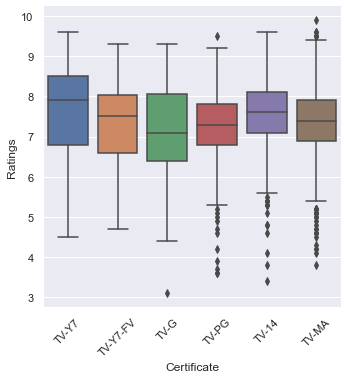

In [32]:
ordered_tv_certificates = ['TV-Y7','TV-Y7-FV','TV-G','TV-PG','TV-14','TV-MA']
graph = sns.catplot(data=proper_tv_ratings, x="certificate_y", y="rating", kind="box", order=ordered_tv_certificates)
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Certificate', 'Ratings')

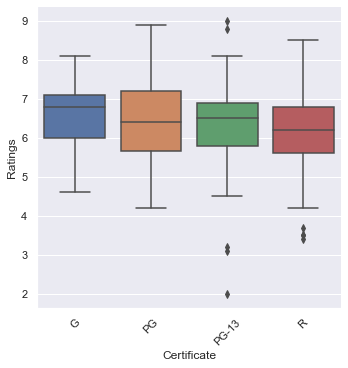

In [33]:
ordered_certificates = ['G','PG','PG-13','R']
graph = sns.catplot(data=proper_movie_ratings, x="certificate_y", y="rating", kind="box", order=ordered_certificates)
graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Certificate', 'Ratings')

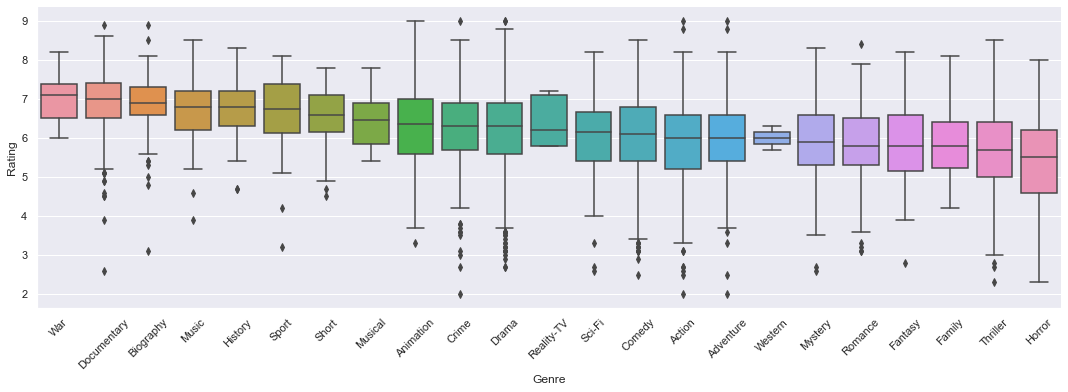

In [34]:
order_low_high = cleaned_movies_genre.groupby('genre')['rating'].median().sort_values(ascending=False).index.values
graph = sns.catplot(data=cleaned_movies_genre, x='genre', y='rating', kind="box", order=order_low_high[1:], aspect=3)

graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Genre', 'Rating')

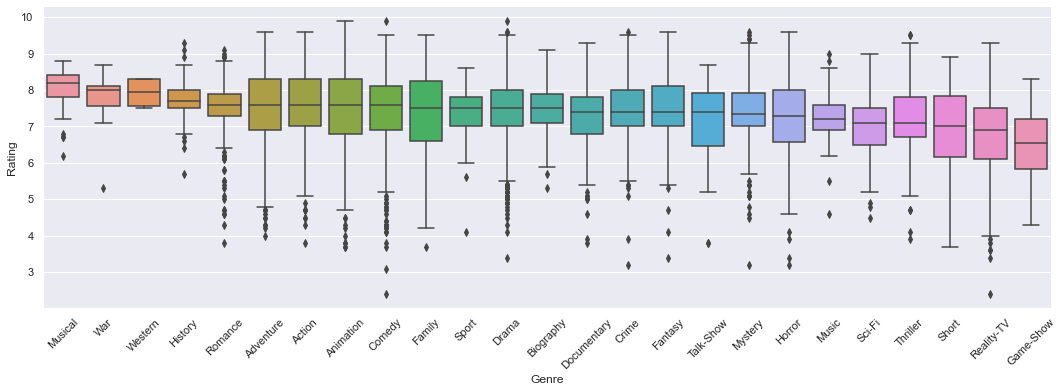

In [35]:
order_low_high = cleaned_tv_shows_genre.groupby('genre')['rating'].median().sort_values(ascending=False).index.values
graph = sns.catplot(data=cleaned_tv_shows_genre, x='genre', y='rating', kind="box", order=order_low_high[1:], aspect=3)

graph.set_xticklabels(rotation=45)
graph.set_axis_labels('Genre', 'Rating')